<a href="https://colab.research.google.com/github/Shanmukha2775/Fmml-lab-2024/blob/main/FMML_M4_L4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOUNDATIONS OF MODERN MACHINE LEARNING, IIIT Hyderabad
# Module 4
## Lab 4: Support Vector Machines

In [ ]:
#Importing the necessary packages
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import pandas
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt

The topic of classifier in today's lab, SVMs make for really good linear separators. Let us look at an example which has linearly separable data:

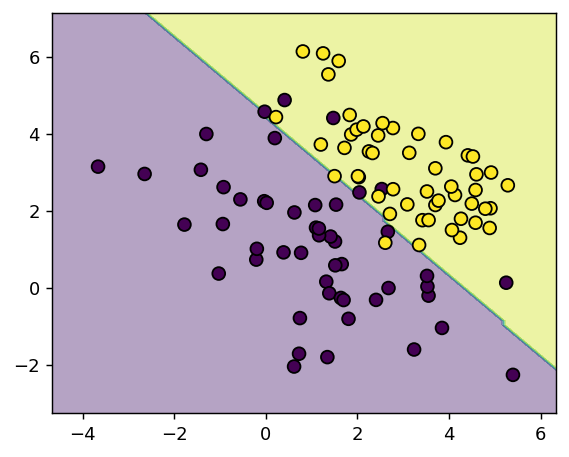

In [ ]:
np.random.seed(0)

ar = np.vstack(     [\
                    np.random.multivariate_normal(np.array([1, 1]), 1.5 * np.array([[2, -1], [-1, 2.0]]), size = 50, ),\
                    np.random.multivariate_normal(np.array([3, 3]), 2 * np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 50, )
                    ]\
              )

testAr = np.vstack(   [\
                      np.random.multivariate_normal(np.array([1, 1]), np.array([[0.5, -0.25], [-0.25, 0.5]]), size = 500, ),\
                      np.random.multivariate_normal(np.array([3, 3]), np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 500, )
                      ]\
                  )
testy = np.array([0] * int((testAr.shape[0]/2)) + [1] * int((testAr.shape[0]/2)))

X = ar
y = np.array([0] * int((ar.shape[0]/2)) + [1] * int((ar.shape[0]/2)))

def plotDecisionBoundary(X, y, pair, clf):
  x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
  y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

  y_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  y_pred = y_pred.reshape(xx.shape)
  plt.figure(figsize=(5,4))
  plt.contourf(xx, yy, y_pred, alpha=0.4)
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c = y, s = 50, edgecolor='k')
  # plt.legend()
  plt.gcf().set_dpi(130)
  plt.show()

def boundaryExp() :
  clf = svm.LinearSVC()
  pair = [0, 1]
  clf.fit(X[:, pair], y)
  plotDecisionBoundary(X, y, pair, clf)

  plt.show()

boundaryExp()

## Intuitive introduction to SVMs:

![SVM](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index3_souoaz.png)

SVMs are an iterative approach of trying to find the optimal hyperplane that divides the multidimentional space into different classes present in the dataset.


**Hyperplanes:** These are the decision planes that separate the objects of classes that we are trying to classify.

**Support Vectors** : Support vectors are the points from dataset that are closest to the hyperplane that divides the dataset.

**Margin**:  The gap between the closest support vectors from the different class along the direction perpendicular to the hyperplane. Simply put, it is the sum of perpendicular distance of the support vector of each class to the hyperplane.

---

Let us try to fall back to the well known dataset and see how SVMs perform on the iris dataset

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
irisData = pandas.DataFrame(\
    data = np.hstack((X,y.reshape(y.shape[0], 1), [[iris["target_names"][int(classIdx)]] for classIdx in y])), \
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', "Class", "ClassName"])
irisData.sample(n = 10, random_state = 1)

,sepal_length,sepal_width,petal_length,petal_width,Class,ClassName
14,5.8,4.0,1.2,0.2,0,setosa
98,5.1,2.5,3.0,1.1,1,versicolor
75,6.6,3.0,4.4,1.4,1,versicolor
16,5.4,3.9,1.3,0.4,0,setosa
131,7.9,3.8,6.4,2.0,2,virginica
56,6.3,3.3,4.7,1.6,1,versicolor
141,6.9,3.1,5.1,2.3,2,virginica
44,5.1,3.8,1.9,0.4,0,setosa
29,4.7,3.2,1.6,0.2,0,setosa
120,6.9,3.2,5.7,2.3,2,virginica


Accuracy of the decision tree on the test set: 

0.921


The confusion matrix is : 


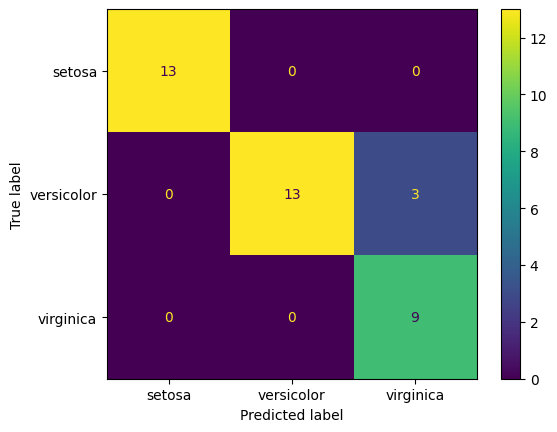

In [ ]:
clf = svm.LinearSVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.0f')

plt.show()

Now lets again try to see how does SVM perform when we give it just two of the features from the dataset

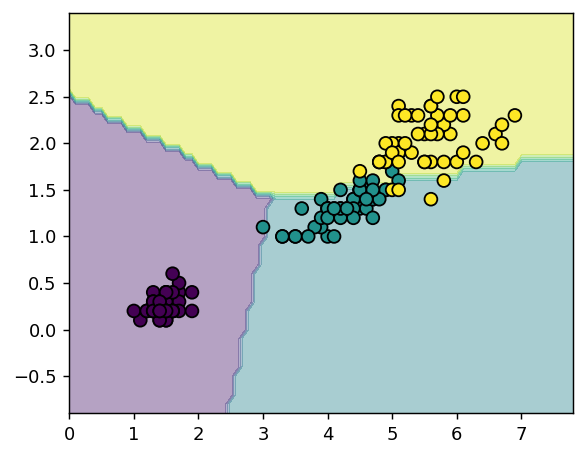

In [ ]:
clf = svm.LinearSVC()
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [2, 3], clf)

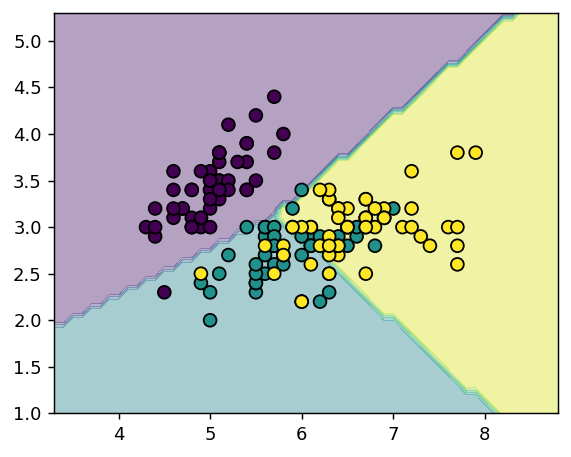

In [ ]:
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

#### Alas! We see that SVMs are not able to classify the data in the above experiment because the data is not **linearly separable**

Thankfully, We have a neat trick up our sleeves that will help us to solve these problems. Let us take a look at a typical example that is used to illustrate this trick before we get back to the above dataset.

---

# The Kernel Trick

The true potential of SVMs is unleashed when they are combined with kernels.

## Kernels : An intuitive explanation

Kernel methods are essentially counting on using the training data (say $i^{th}$ example $(x_i, y_i)$ ) itself in a more straightforward way and learning a corresponding weight ($w_i$) for that example. Rather than trying to learn a fixed set of parameters which is done typically.
Depending on the kind of kernel used, we can virtually project the training data in a higher dimension to make it easier for the classifier to classify them.


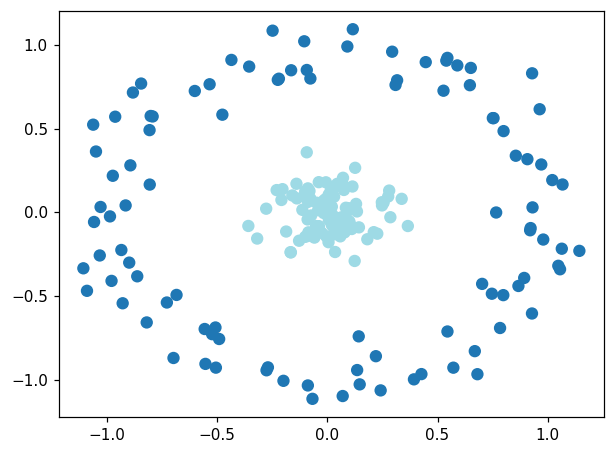

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(200, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab20')
plt.gcf().set_dpi(110)

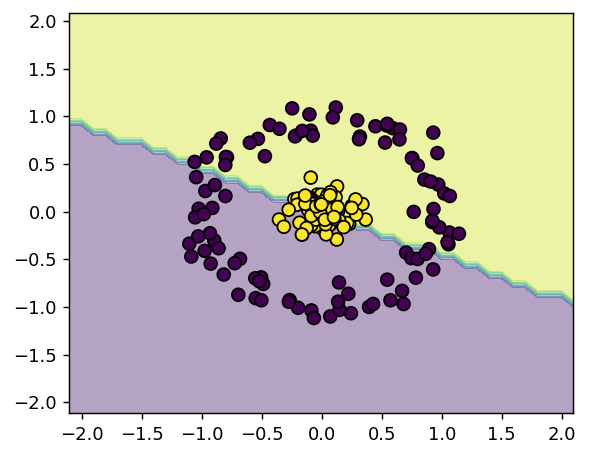

In [ ]:
plt.style.use("default")
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

However, if we artificially add another dimention to the dataset of the form:

$z = x^2 + y^2$
we can clearly see a hyperplane that can distinguish both the datasets:

In [ ]:
Z = np.array([[i[0]**2 + i[1]**2] for i in X])

In [ ]:
X_new = np.hstack((X, Z))

In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure(data = [go.Scatter3d(
    x = X_new[:, 0],
    y = X_new[:, 1],
    z = X_new[:, 2],
    mode = "markers",
    marker = {
        "color" : y,
        "line": {"width" : 4, "color":'DarkSlateGrey'},
        "colorscale": "viridis"},
)])

fig.show()

That simple trick has helped us to get another dimension in which the data is linearly separable by a hyperplane (in this case, a 2d plane)

---

Now let us use the rbf kernel and use an SVM Classifier.

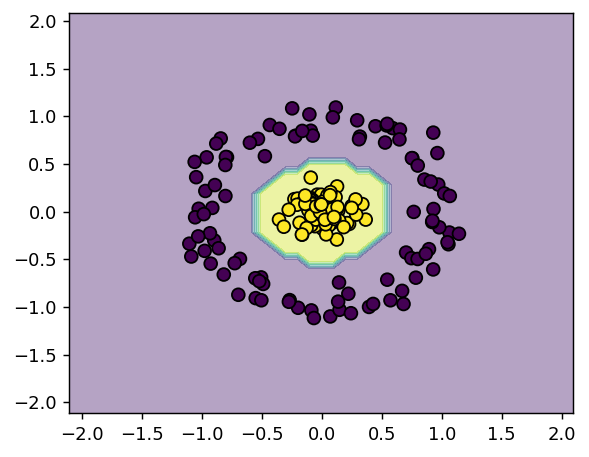

In [ ]:
plt.style.use("default")
clf = svm.SVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

Now let us get back to our original dataset of iris and see if this kernel trick has helped us:

Accuracy of the decision tree on the test set: 

0.974


The confusion matrix is : 


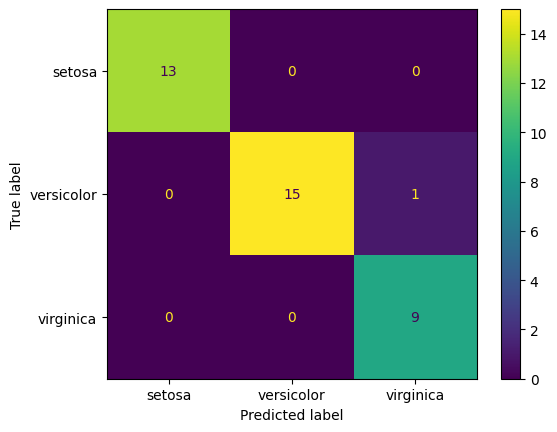

In [ ]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.0f')

plt.show()

Certainly, using a kernel has increased our accuracy on the iris dataset.

Things to try out:
- Try to run the same experiment after filtering different features, 2 at a time.
- Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

ANSWER: 1

Accuracy for features (0, 1): 0.763


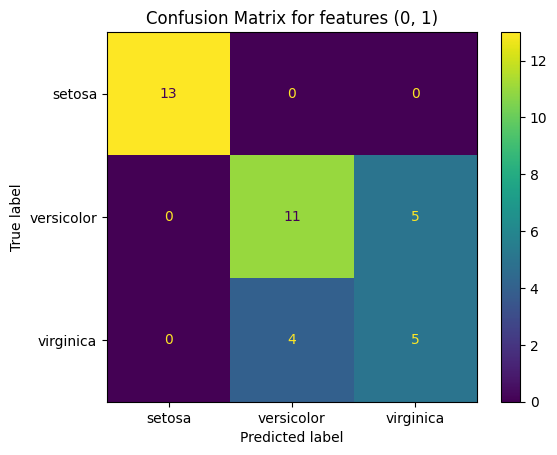

Accuracy for features (0, 2): 0.974


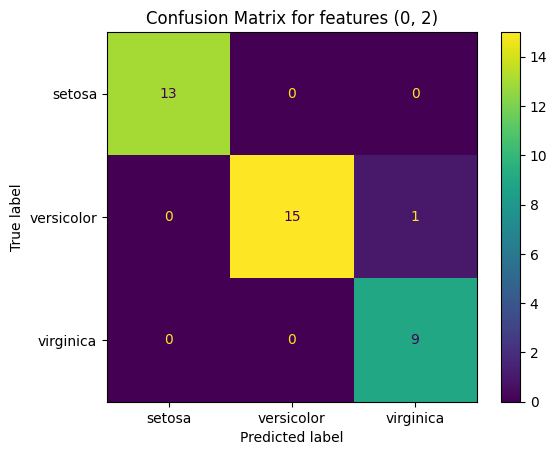

Accuracy for features (0, 3): 0.947


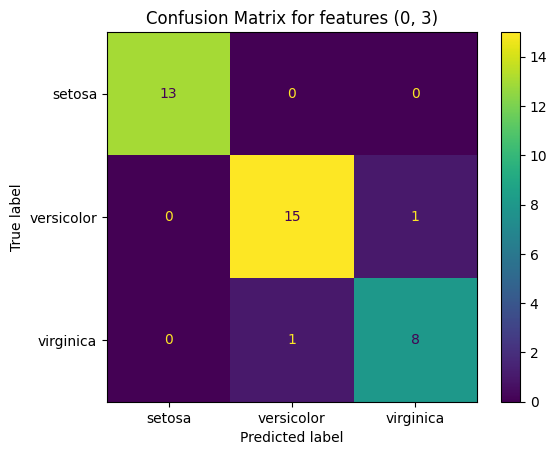

Accuracy for features (1, 2): 0.947


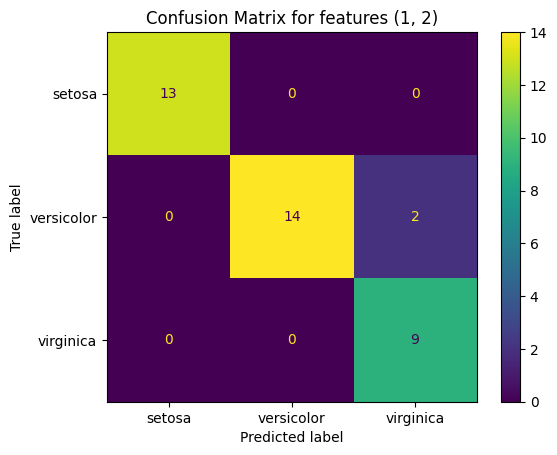

Accuracy for features (1, 3): 0.974


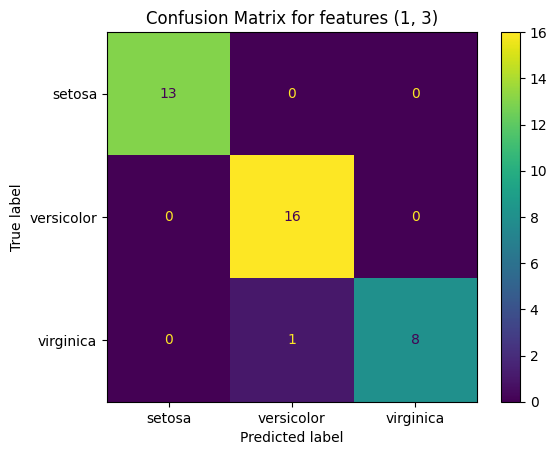

Accuracy for features (2, 3): 0.974


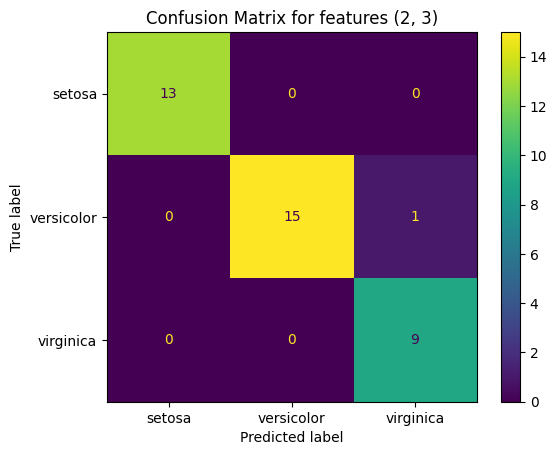

In [ ]:


from itertools import combinations

iris = load_iris()
X, y = iris.data, iris.target

# Get all possible pairs of features
feature_pairs = list(combinations(range(X.shape[1]), 2))

# Train and evaluate SVC for each feature pair
for pair in feature_pairs:
    # Select the features for the current pair
    X_pair = X[:, pair]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y, random_state=0)

    # Train an SVC
    clf = svm.SVC()
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)

    # Print accuracy and display confusion matrix
    accuracy = accuracy_score(y_pred, y_test)
    print(f"Accuracy for features {pair}: {accuracy:.3f}")

    # Display confusion matrix
    class_names = iris["target_names"]
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', values_format='.0f')

    plt.title(f'Confusion Matrix for features {pair}')
    plt.show()

ANSWER: 2

Accuracy for kernel type 'linear': 0.974


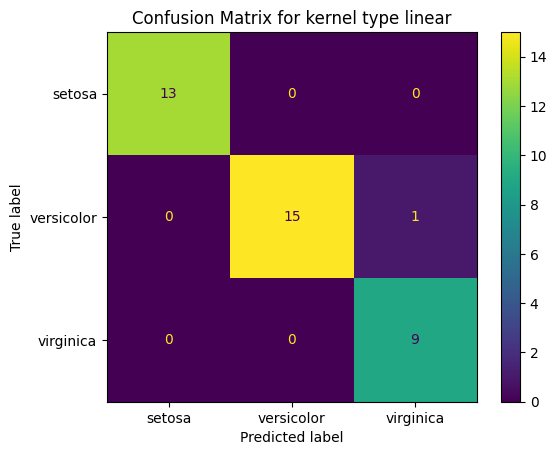

Accuracy for kernel type 'poly': 0.974


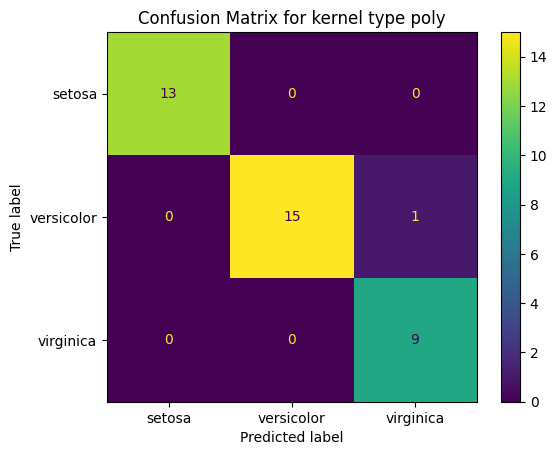

Accuracy for kernel type 'rbf': 0.974


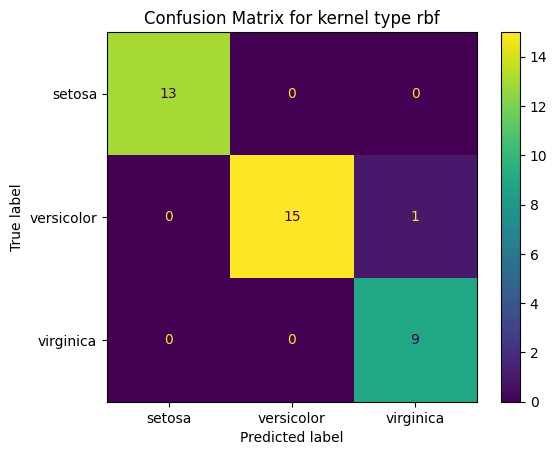

Accuracy for kernel type 'sigmoid': 0.237


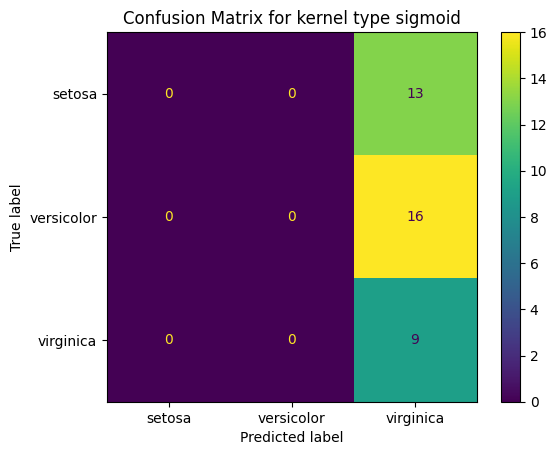

In [ ]:

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

iris = load_iris()
X, y = iris.data, iris.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# List of kernel types to try
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']

# Experiment with different kernels
for kernel_type in kernel_types:
    # Train an SVM with the specified kernel
    clf = svm.SVC(kernel=kernel_type)
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)

    # Print accuracy
    accuracy = accuracy_score(y_pred, y_test)
    print(f"Accuracy for kernel type '{kernel_type}': {accuracy:.3f}")

    # Display confusion matrix
    class_names = iris["target_names"]
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', values_format='.0f')

    plt.title(f'Confusion Matrix for kernel type {kernel_type}')
    plt.show()

## **Additional Critical Thinking Questions**

Consider	a	2-class	classification	problem	in	a	2-dimensional	feature	space	x=[x1,	x2]	with	target	variable	y=±1.	The	training	data	comprises	7
samples	as	shown	in	figure (4	black	diamonds	for	the	positive	class	and	3	white	diamonds	for	the	negative	class). The	“maximum	margin	classifier”
(also	called	linear	“hard	margin”	SVM)	is	a	classifier	that	leaves	the	largest	possible	margin	on	either	side	of	the	decision	boundary.	The	samples	lying	on	the	margin	are	called	support	vectors.

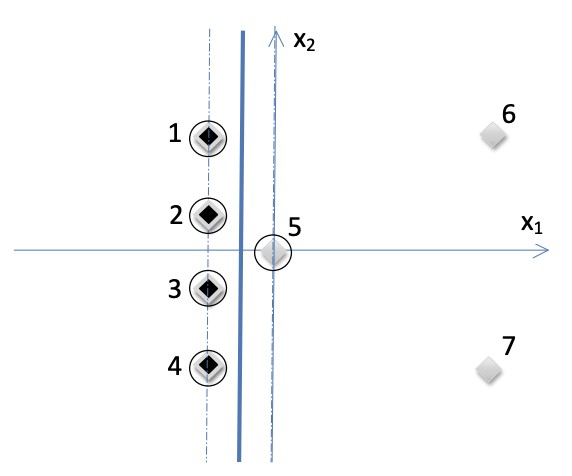


1. Draw	the	decision	boundary	obtained	by	the	linear	hard
margin	SVM	method	with	a	thick	solid	line.	Draw	the	margins	on	either	side with	thinner dashed	lines.	Identify	the	support	vectors.

2. What	is	the	training	error	rate?

3. The	removal	of	which	sample	will	change	the	decision	boundary?

4. What	is	the	leave-one-out	error	rate?


ANSWER: 1

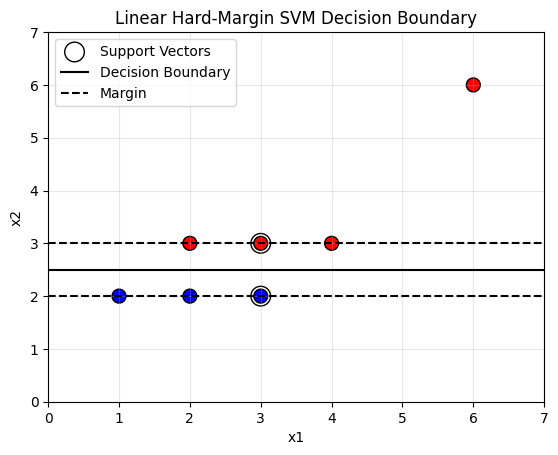

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Define the dataset
X = np.array([
    [2, 3], [3, 3], [4, 3], [1, 2], [2, 2],
    [3, 2], [6, 6]
])
y = np.array([1, 1, 1, -1, -1, -1, 1])  # Labels: +1 and -1

# Train a hard-margin SVM
clf = SVC(kernel='linear', C=1e10)  # Large C approximates hard margin
clf.fit(X, y)

# Get the decision boundary
w = clf.coef_[0]
b = clf.intercept_[0]
x_min, x_max = 0, 7
y_min, y_max = 0, 7

x1 = np.linspace(x_min, x_max, 100)
decision_boundary = -(w[0] / w[1]) * x1 - (b / w[1])
margin1 = decision_boundary - 1 / w[1]
margin2 = decision_boundary + 1 / w[1]

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=100)
plt.scatter(
    X[clf.support_][:, 0], X[clf.support_][:, 1],
    facecolors='none', edgecolor='k', s=200, label="Support Vectors"
)

# Plot the decision boundary and margins
plt.plot(x1, decision_boundary, 'k-', label="Decision Boundary")
plt.plot(x1, margin1, 'k--', label="Margin")
plt.plot(x1, margin2, 'k--')

# Customize the plot
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Linear Hard-Margin SVM Decision Boundary")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.show()

ANSWER: 2

In [ ]:

# Predict the labels of the training data
y_pred = clf.predict(X)

# Calculate the number of misclassified samples
misclassified = np.sum(y != y_pred)

# Calculate the training error rate
training_error_rate = misclassified / len(y)

print(f"Number of misclassified samples: {misclassified}")
print(f"Training Error Rate: {training_error_rate}")

Number of misclassified samples: 0
Training Error Rate: 0.0


ANSWER: 3

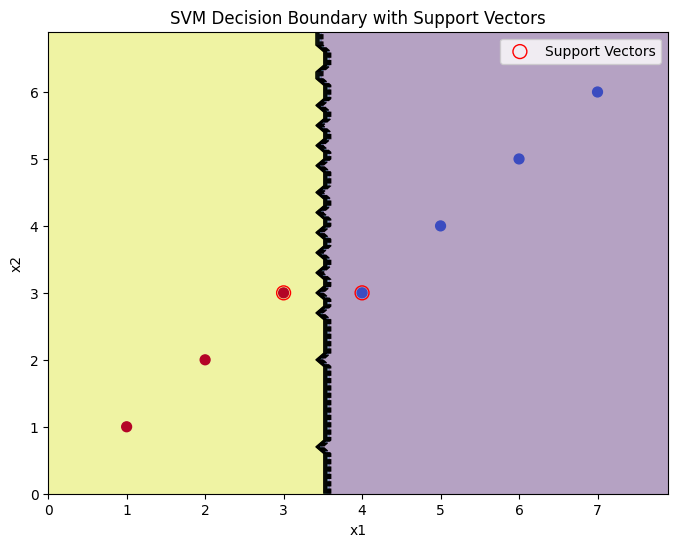

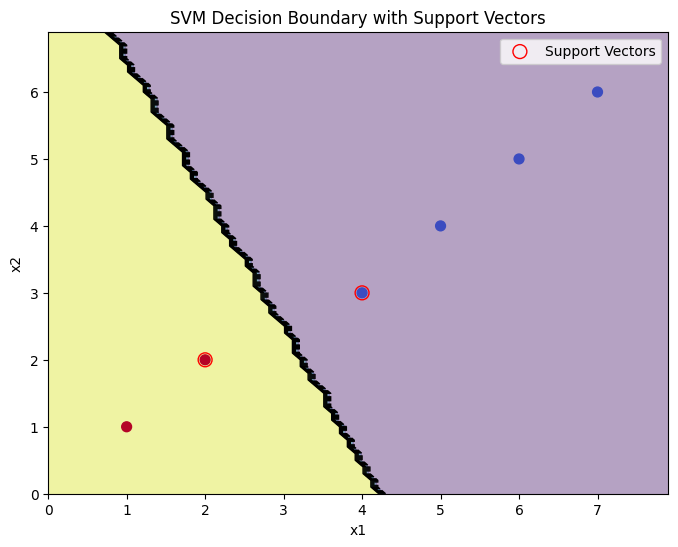

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Training data as described
X = np.array([[1, 1], [2, 2], [3, 3], [4, 3], [5, 4], [6, 5], [7, 6]])
y = np.array([1, 1, 1, -1, -1, -1, -1])  # Classes: 1 (black), -1 (white)

# Function to plot the decision boundary and margins
def plot_decision_boundary(X, y, model, support_vectors=None):
    plt.figure(figsize=(8, 6))

    # Create a mesh grid
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting the decision boundary and margins
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.contour(xx, yy, Z, colors='k', linewidths=1)

    # Plot the support vectors with a red border
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=100, facecolors='none', edgecolors='r', label='Support Vectors')

    # Plot all data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=50, marker='o')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('SVM Decision Boundary with Support Vectors')
    plt.legend(loc='best')
    plt.show()

# Train an SVM with a linear kernel (hard margin)
svm = SVC(kernel='linear', C=1000)  # High C value to enforce a hard margin
svm.fit(X, y)

# Plot the decision boundary and margin with all points
plot_decision_boundary(X, y, svm, support_vectors=svm.support_)

# Remove one support vector (e.g., index 2 or 3)
X_new = np.delete(X, 2, axis=0)  # Remove sample 2
y_new = np.delete(y, 2)

# Train the SVM again with the modified data
svm_new = SVC(kernel='linear', C=1000)
svm_new.fit(X_new, y_new)

# Plot the new decision boundary and margin after removing sample 2
plot_decision_boundary(X_new, y_new, svm_new, support_vectors=svm_new.support_)

ANSWER: 4

In [ ]:

from sklearn.model_selection import LeaveOneOut
from sklearn.svm import SVC
import numpy as np

# Training data as described
X = np.array([[1, 1], [2, 2], [3, 3], [4, 3], [5, 4], [6, 5], [7, 6]])
y = np.array([1, 1, 1, -1, -1, -1, -1])  # Classes: 1 (black), -1 (white)

# Initialize the LeaveOneOut cross-validator
loo = LeaveOneOut()

# Variable to store the number of incorrect predictions
incorrect_predictions = 0
total_predictions = 0

# Loop over the data points for leave-one-out
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the SVM model with a linear kernel (hard margin)
    model = SVC(kernel='linear', C=1000)
    model.fit(X_train, y_train)

    # Make prediction for the left-out point
    y_pred = model.predict(X_test)

    # Count if the prediction was incorrect
    if y_pred != y_test:
        incorrect_predictions += 1

    total_predictions += 1

# Calculate the leave-one-out error rate
loo_error_rate = incorrect_predictions / total_predictions
print(f"Leave-One-Out Error Rate: {loo_error_rate:.4f}")

Leave-One-Out Error Rate: 0.2857



---

Helpful References and sources:

- https://datamites.com/blog/support-vector-machine-algorithm-svm-understanding-kernel-trick/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
